In [1]:
pip install torch transformers scikit-learn numpy accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 280.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 265.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 200.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 209.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 190.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 218.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 226.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install dotenv


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import dotenv
import os
dotenv.load_dotenv("hf.env")
# @title 1.5. For access to Gemma models, log in to HuggingFace 
from huggingface_hub import login
HUGGING_FACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
try:
     login(token=HUGGING_FACE_TOKEN)
     print("Hugging Face login successful (using provided token).")
except Exception as e:
     print(f"Hugging Face login failed. Error: {e}")

Hugging Face login successful (using provided token).


In [60]:
import json
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
# from sklearn.model_selection import train_test_split # Not used directly for split anymore
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import random
import typing
from typing import List, Dict, Tuple, Optional, Any
import re
import functools
import gc
import logging
import sys
import argparse
import os # Import os for path joining

# --- Configuration ---
DATA_FILE = "line_catalog.json"
MODEL_NAME = "google/gemma-2-9b-it"
DEFAULT_LAYER_NAME = "model.layers.7"
VAL_SPLIT_RATIO = 0.2
BATCH_SIZE = 1000
RANDOM_SEED = 42
# *** NEW: Filename for saving splits ***
SPLIT_DATA_FILE = f"data_splits_{DEFAULT_LAYER_NAME}.json"

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Helper Functions ---

def get_prompts(lines: List[str]) -> List[str]:
    """Formats lines into the desired prompt structure."""
    return [f'A rhymed couplet:\n{line}\n' for line in lines]

def get_module_by_name(model: torch.nn.Module, module_name: str) -> Optional[torch.nn.Module]:
    # (Function remains the same)
    names = module_name.split('.')
    module = model
    try:
        for name in names:
            module = getattr(module, name)
        return module
    except AttributeError:
        logging.error(f"Module {module_name} not found in model.")
        logging.info("Attempting to list available layer names...")
        try:
            if hasattr(model, 'model') and hasattr(model.model, 'layers'):
                 logging.info("Available layers in model.model.layers:")
                 for i, _ in enumerate(model.model.layers):
                     logging.info(f"- model.layers.{i}")
            elif hasattr(model, 'layers'):
                 logging.info("Available layers in model.layers:")
                 for i, _ in enumerate(model.layers):
                     logging.info(f"- layers.{i}")
            else:
                logging.info("Could not automatically determine common layer structure.")
                logging.info("Available top-level modules:")
                for name, _ in model.named_children():
                     logging.info(f"- {name}")
        except Exception as e:
            logging.warning(f"Could not inspect layer names: {e}")
        return None

activation_storage: Dict[str, torch.Tensor] = {}

def capture_activation_hook_batch(module: torch.nn.Module, input_tensor: Tuple[torch.Tensor], output: Any, layer_name: str):
    # (Function remains the same)
    output_tensor = output[0] if isinstance(output, tuple) else output
    if isinstance(output_tensor, torch.Tensor):
        activation_storage[layer_name] = output_tensor
    else:
         logging.warning(f"Hook captured non-tensor output for {layer_name}: type {type(output_tensor)}")


def get_activations_batch(
    model: torch.nn.Module,
    tokenizer: Any,
    prompts: List[str],
    layer_name: str,
    device: torch.device
) -> Optional[torch.Tensor]:
    """
    Runs prompts through the model (in a batch) and captures activations
    from the target layer for the last *actual* token of each prompt,
    correctly handling left or right padding.
    Returns a tensor of shape (num_prompts, hidden_dim).
    """
    global activation_storage
    activation_storage = {}

    target_module = get_module_by_name(model, layer_name)
    if target_module is None:
        logging.error(f"Target module {layer_name} could not be found. Cannot attach hook.")
        return None

    hook_handle = target_module.register_forward_hook(
        functools.partial(capture_activation_hook_batch, layer_name=layer_name)
    )

    last_token_activations = None
    try:
        # Tokenizer already configured for padding side before calling this
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        with torch.no_grad():
            _ = model(**inputs, output_hidden_states=False)

            if layer_name in activation_storage:
                layer_activations = activation_storage[layer_name].to(device) # Shape: (batch_size, seq_len, hidden_dim)
                batch_indices = torch.arange(layer_activations.size(0), device=device)

                # *** MODIFIED: Get last token index based on padding side ***
                if tokenizer.padding_side == 'left':
                    # With left padding, the last *actual* token is always at the final sequence position
                    # Select activations from the very last sequence position for all items in the batch
                    last_token_activations = layer_activations[:, -1, :]
                elif tokenizer.padding_side == 'right':
                    # With right padding, find the last non-padding token using attention mask sum
                    last_token_indices = attention_mask.sum(dim=1) - 1
                    last_token_activations = layer_activations[batch_indices, last_token_indices, :]
                else:
                    # Should not happen if we set it explicitly, but good practice to check
                    logging.error(f"Unsupported padding side: {tokenizer.padding_side}. Cannot determine last token.")
                    # Clean up hook before returning None
                    hook_handle.remove()
                    return None
                # *** END MODIFICATION ***

                del activation_storage[layer_name] # Clear storage
                if layer_name in activation_storage: del activation_storage[layer_name] # Belt and suspenders

            else:
                logging.warning(f"Activation for layer {layer_name} not captured in hook for batch starting with: '{prompts[0][:50]}...'")

    except Exception as e:
        logging.error(f"Error during forward pass or activation processing: {e}", exc_info=True)
        if 'hook_handle' in locals() and hook_handle is not None: hook_handle.remove()
        if layer_name in activation_storage: del activation_storage[layer_name]
        gc.collect(); torch.cuda.empty_cache()
        return None

    finally:
        if 'hook_handle' in locals() and hook_handle is not None: hook_handle.remove()
        activation_storage = {}
        if device.type == 'cuda': gc.collect(); torch.cuda.empty_cache()

    # Ensure shape is (batch_size, hidden_dim)
    if last_token_activations is not None and last_token_activations.ndim == 3:
        # This case should ideally not happen with the corrected logic, but as a safeguard:
        logging.warning("Activation tensor unexpectedly had 3 dimensions after selection. Squeezing.")
        last_token_activations = last_token_activations.squeeze(1) # Adjust dimension if needed

    # Final check on shape
    if last_token_activations is not None and last_token_activations.ndim != 2:
         logging.error(f"Final activation tensor has unexpected shape: {last_token_activations.shape}. Expected (batch_size, hidden_dim).")
         return None


    return last_token_activations


def extract_activations_in_batches(
    model: torch.nn.Module,
    tokenizer: Any,
    raw_lines: List[str],
    layer_name: str,
    batch_size: int,
    device: torch.device
) -> Optional[np.ndarray]:
    # (Function logic remains the same, relies on get_activations_batch handling padding)
    all_activations = []
    model.eval()

    formatted_prompts = get_prompts(raw_lines)
    num_prompts = len(formatted_prompts)

    for i in range(0, num_prompts, batch_size):
        batch_prompts = formatted_prompts[i : i + batch_size]
        logging.info(f"Processing batch {i // batch_size + 1}/{(num_prompts + batch_size - 1) // batch_size}...")

        batch_activations = get_activations_batch(model, tokenizer, batch_prompts, layer_name, device)

        if batch_activations is None:
            logging.error(f"Failed to get activations for batch starting at index {i}. Aborting.")
            return None

        all_activations.append(batch_activations.cpu().float().numpy())

        if i % (batch_size * 5) == 0:
            gc.collect()
            if device.type == 'cuda': torch.cuda.empty_cache()

    if not all_activations: return np.array([])

    try:
        final_activations = np.concatenate(all_activations, axis=0)
    except ValueError as e:
        logging.error(f"Error during concatenation: {e}")
        logging.error(f"Shapes of collected activation batches: {[a.shape for a in all_activations]}")
        return None

    return final_activations

def get_last_word(text: str) -> str:
    # (Function remains the same)
    words = re.findall(r'\b\w+\b', text.lower())
    return words[-1] if words else ""

# --- Main Script ---
def main(use_half_data: bool):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(RANDOM_SEED)

    # --- 1. Load Data ---
    logging.info(f"Loading data from {DATA_FILE}...")
    # (Loading logic remains the same)
    try:
        with open(DATA_FILE, 'r') as f: rhyme_data = json.load(f)
    except json.JSONDecodeError:
        logging.error(f"Error: Could not decode JSON from '{DATA_FILE}'.")
        raise ValueError(f"Invalid JSON format in {DATA_FILE}")

    all_lines_data: List[Tuple[str, str]] = []
    for rhyme_class, examples in rhyme_data.items():
        for line in examples: all_lines_data.append((line, rhyme_class))

    if not all_lines_data: raise ValueError("No data loaded from JSON file.")

    # Subsample Data if Requested
    if use_half_data:
        logging.info(f"Using only half ({len(all_lines_data) // 2}) of the data as requested.")
        random.shuffle(all_lines_data)
        midpoint = len(all_lines_data) // 2
        all_lines_data = all_lines_data[:midpoint]
        if not all_lines_data: raise ValueError("Subsampling resulted in no data.")

    logging.info(f"Processing {len(all_lines_data)} lines across {len(set(c for _,c in all_lines_data))} classes.")

    # --- 2. Custom Data Splitting ---
    # (Splitting logic remains the same - operates on raw lines before tokenization)
    logging.info("Splitting data into training and validation sets...")
    # ... (Keep the existing splitting logic based on last words) ...
    # ... (Assume train_data and val_data are created as before) ...

    # --- Make sure splitting logic produces train_data and val_data lists ---
    # Placeholder for the detailed splitting logic from the previous version
    # Ensure it produces:
    # train_data: List[Tuple[str, str]]
    # val_data: List[Tuple[str, str]]
    # You would paste the full splitting logic block here.
    # For brevity, I'm assuming it runs and generates the lists.
    # --- Start Placeholder for Splitting Logic ---
    lines_by_last_word = defaultdict(list)
    valid_indices_for_split = []
    for i, (line, rhyme_class) in enumerate(all_lines_data):
        last_word = get_last_word(line)
        if last_word:
            lines_by_last_word[last_word].append(i)
            valid_indices_for_split.append(i)
        else:
             logging.warning(f"Could not find last word for line index {i}: '{line}'. Excluding from split.")
    valid_lines_data = [all_lines_data[i] for i in valid_indices_for_split]
    valid_lines_by_last_word = defaultdict(list)
    current_valid_index = 0
    original_to_valid_map = {}
    for i, (line, rhyme_class) in enumerate(all_lines_data):
         if i in valid_indices_for_split:
             original_to_valid_map[i] = current_valid_index
             current_valid_index += 1
    for last_word, original_indices in lines_by_last_word.items():
        valid_lines_by_last_word[last_word] = [original_to_valid_map[orig_idx] for orig_idx in original_indices]
    unique_last_words = list(valid_lines_by_last_word.keys())
    random.shuffle(unique_last_words)
    all_classes = set(rhyme_class for _, rhyme_class in valid_lines_data)
    if not all_classes: raise ValueError("No usable data for splitting.")
    train_indices_set_valid = set()
    val_indices_set_valid = set()
    assigned_last_words = set()
    val_target_group_count = max(1, int(len(unique_last_words) * VAL_SPLIT_RATIO))
    words_by_class = defaultdict(list)
    for word, indices in valid_lines_by_last_word.items():
        classes_in_group = set(valid_lines_data[idx][1] for idx in indices)
        for cls in classes_in_group: words_by_class[cls].append(word)
    train_classes_present = set(); val_classes_present = set()
    for cls in sorted(list(all_classes)):
        assigned_to_val = False
        if cls not in val_classes_present and words_by_class[cls]:
            random.shuffle(words_by_class[cls])
            for word in words_by_class[cls]:
                 if word not in assigned_last_words:
                     val_indices_set_valid.update(valid_lines_by_last_word[word])
                     assigned_last_words.add(word); val_classes_present.update(set(valid_lines_data[idx][1] for idx in valid_lines_by_last_word[word]))
                     assigned_to_val = True; break
        assigned_to_train = False
        if cls not in train_classes_present and words_by_class[cls]:
            random.shuffle(words_by_class[cls])
            for word in words_by_class[cls]:
                if word not in assigned_last_words:
                    train_indices_set_valid.update(valid_lines_by_last_word[word])
                    assigned_last_words.add(word); train_classes_present.update(set(valid_lines_data[idx][1] for idx in valid_lines_by_last_word[word]))
                    assigned_to_train = True; break
        if words_by_class[cls] and not assigned_to_val and cls not in val_classes_present: logging.warning(f"Could not assign unique word group to VAL for class '{cls}'.")
        if words_by_class[cls] and not assigned_to_train and cls not in train_classes_present: logging.warning(f"Could not assign unique word group to TRAIN for class '{cls}'.")
    remaining_words = [w for w in unique_last_words if w not in assigned_last_words]; random.shuffle(remaining_words)
    num_val_groups_assigned = len({w for w in assigned_last_words if any(idx in val_indices_set_valid for idx in valid_lines_by_last_word[w])})
    for word in remaining_words:
         indices_for_word = valid_lines_by_last_word[word]
         if num_val_groups_assigned < val_target_group_count:
             val_indices_set_valid.update(indices_for_word); assigned_last_words.add(word); num_val_groups_assigned += 1
         else:
             train_indices_set_valid.update(indices_for_word); assigned_last_words.add(word)
    train_data = [valid_lines_data[i] for i in sorted(list(train_indices_set_valid))]
    val_data = [valid_lines_data[i] for i in sorted(list(val_indices_set_valid))]
    final_train_classes = set(c for _, c in train_data); final_val_classes = set(c for _, c in val_data)
    missing_train = all_classes - final_train_classes; missing_val = all_classes - final_val_classes
    if missing_train: logging.warning(f"Train set missing classes: {missing_train}.")
    if missing_val: logging.warning(f"Validation set missing classes: {missing_val}.")
    # --- End Placeholder for Splitting Logic ---

    logging.info(f"Split complete: {len(train_data)} training samples, {len(val_data)} validation samples.")
    logging.info(f"Training classes ({len(final_train_classes)}): {sorted(list(final_train_classes))}")
    logging.info(f"Validation classes ({len(final_val_classes)}): {sorted(list(final_val_classes))}")

    # *** NEW: Save the splits ***
    logging.info(f"Saving train/validation splits to {SPLIT_DATA_FILE}...")
    split_data_to_save = {
        "train": train_data,
        "validation": val_data
    }
    try:
        with open(SPLIT_DATA_FILE, 'w') as f:
            json.dump(split_data_to_save, f, indent=4)
        logging.info("Successfully saved data splits.")
    except IOError as e:
        logging.error(f"Failed to save data splits to {SPLIT_DATA_FILE}: {e}")
    except TypeError as e:
         logging.error(f"Failed to serialize split data to JSON: {e}")


    # --- 3. Load Model and Tokenizer ---
    logging.info(f"Loading model and tokenizer: {MODEL_NAME}...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )

        # Set Pad Token
        if tokenizer.pad_token is None:
            if tokenizer.eos_token:
                 tokenizer.pad_token = tokenizer.eos_token
                 logging.info(f"Set tokenizer pad_token to eos_token ({tokenizer.eos_token})")
            else:
                 logging.warning("EOS token not found. Adding a new pad token '[PAD]'.")
                 tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                 model.resize_token_embeddings(len(tokenizer))

        # *** Set Padding Side to Left ***
        logging.info("Setting tokenizer padding side to 'left'.")
        tokenizer.padding_side = 'left'
        # Note: Ensure the model you are using works correctly with left padding.
        # Most causal LMs do, especially for batched inference.

        # Verify Layer Exists
        target_layer = get_module_by_name(model, DEFAULT_LAYER_NAME)
        if target_layer is None:
            logging.error(f"Target layer name {DEFAULT_LAYER_NAME} is invalid for {MODEL_NAME}.")
            return None
        else:
             logging.info(f"Confirmed layer {DEFAULT_LAYER_NAME} exists.")
             layer_name = DEFAULT_LAYER_NAME

    except Exception as e:
        logging.error(f"Error loading model or tokenizer: {e}", exc_info=True)
        return None

    # --- 4. Feature Extraction (Activations) ---
    # (No changes needed here, logic moved into get_activations_batch/extract...)
    logging.info("Extracting activations for training data...")
    train_lines_raw = [line for line, rhyme_class in train_data]
    X_train_activations = extract_activations_in_batches(model, tokenizer, train_lines_raw, layer_name, BATCH_SIZE, device)

    if X_train_activations is None:
        logging.error("Failed to extract training activations.")
        del model, tokenizer; gc.collect(); torch.cuda.empty_cache()
        return None

    logging.info("Extracting activations for validation data...")
    val_lines_raw = [line for line, rhyme_class in val_data]
    X_val_activations = extract_activations_in_batches(model, tokenizer, val_lines_raw, layer_name, BATCH_SIZE, device)

    if X_val_activations is None:
        logging.error("Failed to extract validation activations.")
        del model, tokenizer; gc.collect(); torch.cuda.empty_cache()
        return None

    logging.info(f"Training activations shape: {X_train_activations.shape}")
    logging.info(f"Validation activations shape: {X_val_activations.shape}")

    # --- Clear Model from Memory ---
    logging.info("Clearing model from memory...")
    del model; del tokenizer; gc.collect()
    if device.type == 'cuda': torch.cuda.empty_cache()

    # --- 5. Prepare Labels ---
    # (No changes needed here)
    logging.info("Encoding labels...")
    le = LabelEncoder()
    train_labels = [rhyme_class for line, rhyme_class in train_data]
    val_labels = [rhyme_class for line, rhyme_class in val_data]
    present_labels = list(set(train_labels + val_labels))
    if not present_labels:
        logging.error("No labels found in the final train/val splits.")
        return None
    le.fit(present_labels)
    y_train = le.transform(train_labels)
    y_val = le.transform(val_labels)
    idx_to_class = {i: cls for i, cls in enumerate(le.classes_)}
    class_to_idx = {cls: i for i, cls in idx_to_class.items()}
    logging.info(f"Classes mapped ({len(le.classes_)}): {class_to_idx}")

    # --- 6. Train Linear Probe ---
    # (No changes needed here)
    logging.info("Training the linear probe (Logistic Regression)...")
    probe = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=RANDOM_SEED, max_iter=1000, C=1.0)
    probe.fit(X_train_activations, y_train)
    logging.info("Probe training complete.")

    # --- 7. Evaluate ---
    # (No changes needed here)
    logging.info("Evaluating probe accuracy...")
    train_accuracy = probe.score(X_train_activations, y_train)
    val_accuracy = probe.score(X_val_activations, y_val)
    print("\n--- Probe Evaluation ---")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("------------------------\n")

    # --- 8. Extract Weights ---
    # (No changes needed here)
    logging.info("Extracting weight vectors...")
    class_weights = {}
    # ... (Keep weight extraction logic) ...
    if hasattr(probe, 'coef_'):
         weights = probe.coef_
         if len(le.classes_) == 2:
             if weights.shape[0] == 1:
                 class_weights[idx_to_class[1]] = weights[0].tolist()
                 class_weights[idx_to_class[0]] = (-weights[0]).tolist()
             elif weights.shape[0] == 2:
                 for i, class_name in enumerate(le.classes_): class_weights[class_name] = weights[i].tolist()
             else: logging.warning(f"Unexpected weight shape for binary classification: {weights.shape}")
         elif weights.shape[0] == len(le.classes_):
              for i, class_name in enumerate(le.classes_): class_weights[class_name] = weights[i].tolist()
         else:
             logging.error(f"Mismatch between classes ({len(le.classes_)}) and weights ({weights.shape[0]})"); class_weights = None
    else:
        logging.error("Could not retrieve weights ('coef_')"); class_weights = None

    # Return weights
    if class_weights:
        logging.info(f"Successfully extracted weights for {len(class_weights)} classes.")
        return class_weights
    else:
        logging.error("Failed to extract class weights.")
        return None


if __name__ == "__main__":
    try:
        with open(DATA_FILE, 'r') as f: pass
        logging.info(f"Using data file: {DATA_FILE}")
    except FileNotFoundError:
        logging.error(f"FATAL: Data file '{DATA_FILE}' not found."); sys.exit(1)
    except Exception as e:
        logging.error(f"FATAL: Error accessing data file '{DATA_FILE}': {e}"); sys.exit(1)

    # Run main function
    extracted_weights = None
    try:
        extracted_weights = main(use_half_data=False)
    except Exception as e:
        logging.error(f"An error occurred during main execution: {e}", exc_info=True); sys.exit(1)

    # Process results
    if extracted_weights:
        logging.info("\n--- Extracted Class Weights ---")
        try:
            weights_filename = f"rhyme_probe_weights_{DEFAULT_LAYER_NAME}.json"
            with open(weights_filename, "w") as f:
                 json.dump(extracted_weights, f, indent=4)
            logging.info(f"Saved extracted weights to {weights_filename}")
        except Exception as e:
             logging.error(f"Failed to save weights to file: {e}")
    else:
        logging.warning("Script finished, but no weights were extracted or returned successfully.")

2025-04-27 16:04:36,145 - INFO - Using data file: line_catalog.json
2025-04-27 16:04:36,147 - INFO - Loading data from line_catalog.json...
2025-04-27 16:04:36,150 - INFO - Processing 1200 lines across 12 classes.
2025-04-27 16:04:36,151 - INFO - Splitting data into training and validation sets...
2025-04-27 16:04:36,165 - INFO - Split complete: 943 training samples, 257 validation samples.
2025-04-27 16:04:36,165 - INFO - Training classes (12): ['bake_rhymes', 'band_rhymes', 'call_rhymes', 'doom_rhymes', 'night_rhymes', 'pain_rhymes', 'shore_rhymes', 'sing_rhymes', 'skies_rhymes', 'sleep_rhymes', 'slick_rhymes', 'unfold_rhymes']
2025-04-27 16:04:36,165 - INFO - Validation classes (12): ['bake_rhymes', 'band_rhymes', 'call_rhymes', 'doom_rhymes', 'night_rhymes', 'pain_rhymes', 'shore_rhymes', 'sing_rhymes', 'skies_rhymes', 'sleep_rhymes', 'slick_rhymes', 'unfold_rhymes']
2025-04-27 16:04:36,166 - INFO - Saving train/validation splits to data_splits_model.layers.7.json...
2025-04-27 16:

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-04-27 16:04:41,864 - INFO - Setting tokenizer padding side to 'left'.
2025-04-27 16:04:41,864 - INFO - Confirmed layer model.layers.7 exists.
2025-04-27 16:04:41,865 - INFO - Extracting activations for training data...
2025-04-27 16:04:41,867 - INFO - Processing batch 1/1...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2025-04-27 16:04:57,131 - INFO - Extracting activations for validation data...
2025-04-27 16:04:57,134 - INFO - Processing batch 1/1...
2025-04-27 16:05:08,446 - INFO - Training activations shape: (943, 3584)
2025-04-27 16:05:08,447 - INFO - Validation activations shape: (257, 3584)
2025-04-27 16:05:08,447 - INFO - Clearing model from memory...
2025-04-27 16:05:08,897 - INFO - Encoding labels...
2025-04-27 16:05:08,902 - INFO - Classes mapped (12): {np.str_('bake_rhymes'): 0, np.str_('band_rhymes'): 1, np.str_('call_rhymes'): 2, np.str_('doom_rhymes'): 3, np.str_('night_r


--- Probe Evaluation ---
Training Accuracy: 1.0000
Validation Accuracy: 0.8288
------------------------



In [5]:
quantization_config = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32 # BF16 recommended on Ampere+
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
# Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    quantization_config=quantization_config,
    device_map="auto", # Automatically distribute across GPUs if available
    # use_auth_token=YOUR_HF_TOKEN, # Add if model requires authentication
    trust_remote_code=True # Gemma requires this for some versions/variants
)

print(f"Model loaded on device(s): {model.hf_device_map}")

# --- IMPORTANT: Finding the Layer Name ---
# Uncomment the following line to print the model structure and find the exact layer name
# print(model)
# Look for layers like 'model.layers[INDEX].mlp...' or 'model.layers[INDEX].self_attn...'

# Ensure model is in evaluation mode
model.eval()

2025-04-27 13:59:36,031 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded on device(s): {'': 0}


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 3584, padding_idx=0)
    (layers): ModuleList(
      (0-41): 42 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (up_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=3584, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (pre_feedforward_layernorm): G

In [7]:
import numpy as np
from typing import List, Tuple, Union, Optional, Dict, Any

def unembed_vector(
    vector: Union[torch.Tensor, np.ndarray],
    model=model,
    tokenizer=tokenizer,
    use_transpose: bool = False,
    top_k: int = 10,
    token_list: Optional[List[str]] = None,
    device: Optional[str] = None,
    dtype: Optional[torch.dtype] = None
) -> Dict[str, Any]:
    """
    Unembed a vector using either the unembedding matrix or the transpose of the embedding matrix.
    
    Args:
        vector: The vector to unembed (1D tensor or numpy array)
        model_name: The Gemma model name
        use_transpose: If True, use the transpose of the embedding matrix; if False, use the unembedding matrix
        top_k: Number of top tokens to return
        token_list: List of specific tokens to compute logits for
        device: Device to run computation on ('cuda', 'cpu'). If None, will use CUDA if available.
        dtype: Data type to use for computation. If None, will match the model's dtype.
        
    Returns:
        Dictionary containing:
            - top_tokens: List of (token, score) pairs for top tokens
            - specific_logits: Dictionary mapping tokens to their logits (if token_list provided)
    """
    # Determine device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    # Determine dtype to use (match the model's dtype if not specified)
    if dtype is None:
        # Get model's dtype from embedding weights
        model_dtype = model.get_input_embeddings().weight.dtype
        dtype = model_dtype
    
    # Ensure vector is a torch tensor with correct dtype and device
    if isinstance(vector, np.ndarray):
        vector = torch.tensor(vector, dtype=dtype, device=device)
    else:
        vector = vector.to(device=device, dtype=dtype)
    
    if vector.dim() > 1:
        # Flatten if needed - assuming the input might be a 2D embedding
        vector = vector.squeeze()
    
    # Get the appropriate matrix for unembedding
    with torch.no_grad():
        if use_transpose:
            # Use the transpose of the embedding matrix
            embedding_matrix = model.get_input_embeddings().weight
            unembedding_matrix = embedding_matrix.transpose(0, 1)
        else:
            # Use the unembedding matrix (lm_head)
            unembedding_matrix = model.lm_head.weight.transpose(0, 1)
    
    # Ensure the vector has the correct shape to match the unembedding matrix
    if vector.shape[0] != unembedding_matrix.shape[0]:
        raise ValueError(f"Vector dimension ({vector.shape[0]}) does not match unembedding matrix input dimension ({unembedding_matrix.shape[0]})")
    
    # Compute the unembedded logits (using matrix-vector multiplication)
    with torch.no_grad():  # No need to track gradients for inference
        logits = torch.matmul(vector, unembedding_matrix)
    
    # Get the top-k token IDs based on logits
    top_values, top_indices = torch.topk(logits, k=top_k)
    
    # Convert to tokens and build result list
    top_tokens = []
    for idx, (token_id, score) in enumerate(zip(top_indices.tolist(), top_values.tolist())):
        token = tokenizer.decode(token_id)
        top_tokens.append((token, score))
    
    result = {
        "top_tokens": top_tokens,
    }
    
    # Calculate logits for specific tokens if provided
    if token_list is not None:
        specific_logits = {}
        specific_ranks = {}
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        token_to_rank = {idx.item(): rank for rank, idx in enumerate(sorted_indices)}

        for token in token_list:
            token_ids = tokenizer.encode(token, add_special_tokens=False)
            if token_ids:
                token_id = token_ids[0]
                logit = logits[token_id].item()
                rank = token_to_rank.get(token_id, None)
                specific_logits[token] = logit
                specific_ranks[token] = rank
            else:
                specific_logits[token] = float('nan')
                specific_ranks[token] = None

        result["specific_logits"] = specific_logits
        result["specific_ranks"] = specific_ranks
    
    return result

In [8]:
def percentage_positive_second(pairs):
    if not pairs:
        return 0.0

    count = sum(1 for x, y in pairs if y > 0)
    return (count / len(pairs)) * 100

In [66]:
def percentage_first_thousand(pairs,threshold=1000):
    if not pairs:
        return 0.0

    count = sum(1 for x, y in pairs if y < threshold)
    return (count / len(pairs)) * 100

In [10]:
def last_sound(s):
    return s.split('_')[0][-1]

In [11]:
label1=str(list(extracted_weights.items())[1][0])

In [12]:
last_sound(label1)

'd'

In [13]:
last_sounds={}
for i in range(12):
    label = str(list(extracted_weights.items())[i][0])
    last_sounds[label]=last_sound(label)

In [14]:
last_sounds={'bake_rhymes': 'k',
 'band_rhymes': 'd',
 'call_rhymes': 'l',
 'doom_rhymes': 'm',
 'night_rhymes': 't',
 'pain_rhymes': 'n',
 'shore_rhymes': 'r',
 'sing_rhymes': 'g',
 'skies_rhymes': 's',
 'sleep_rhymes': 'p',
 'slick_rhymes': 'k',
 'unfold_rhymes': 'd'}

In [15]:
last_sounds.keys()

dict_keys(['bake_rhymes', 'band_rhymes', 'call_rhymes', 'doom_rhymes', 'night_rhymes', 'pain_rhymes', 'shore_rhymes', 'sing_rhymes', 'skies_rhymes', 'sleep_rhymes', 'slick_rhymes', 'unfold_rhymes'])

In [29]:
with open (SPLIT_DATA_FILE,'r')as f: 
    splits=json.load(f)

In [19]:
train_words=[p[0].split()[-1] for p in splits['train']]

In [20]:
validation_words=[p[0].split()[-1] for p in splits['validation']]

In [22]:
len(set(train_words).intersection(set(validation_words)))

0

In [23]:
rhymes={i: [] for i in last_sounds.keys()}

In [24]:
for p in splits['train']+splits['validation']:
    rhymes[p[1]].append(p[0].split()[-1])

In [32]:
for i in range(12):
    label=list(extracted_weights.items())[i][0]
    print(label)
    rhymelist=list(set(rhymes[label]))
    last_s=last_sounds[label]
    v=unembed_vector(torch.tensor(list(extracted_weights.items())[i][1]),top_k=1000,token_list=rhymelist)
    smp=[i[0] for i in v['top_tokens'][:100]]
    random.shuffle(smp)
    print("\trandom top logits:\n",smp[:5])
    print("\tPercentage positive logits for words in rhyme family:",round(percentage_positive_second(v['specific_logits'].items()),2))
    print("\tPercentage top 1K logits for words in rhyme family:",round(percentage_first_thousand(v['specific_ranks'].items()),2))
    print("Count of",last_s,"in top tokens:",len([i for i in v['top_tokens'] if last_s in i[0] or last_s.upper() in i[0]]))
    print()

bake_rhymes
	random top logits:
 ['knex', 'Reply', ' springfox', ' comesti', 'IBAction']
	Percentage positive logits for words in rhyme family: 90.91
	Percentage top 1K logits for words in rhyme family: 36.36
Count of k in top tokens: 138

band_rhymes
	random top logits:
 ['identity', 'housie', ' Central', ' HAND', ' Branding']
	Percentage positive logits for words in rhyme family: 92.31
	Percentage top 1K logits for words in rhyme family: 23.08
Count of d in top tokens: 302

call_rhymes
	random top logits:
 ['EndProject', 'thering', 'Incident', 'pertino', ' informe']
	Percentage positive logits for words in rhyme family: 100.0
	Percentage top 1K logits for words in rhyme family: 50.0
Count of l in top tokens: 398

doom_rhymes
	random top logits:
 [' gloom', 'thalle', 'TASK', 'AnimationsModule', ' Mühle']
	Percentage positive logits for words in rhyme family: 90.0
	Percentage top 1K logits for words in rhyme family: 30.0
Count of m in top tokens: 193

night_rhymes
	random top logits:
 

In [27]:
#layer 20
with open("rhyme_probe_weights.json", 'r') as f:
    extracted_weights=json.load(f)
for i in range(12):
    label=list(extracted_weights.items())[i][0]
    print(label)
    rhymelist=list(set(rhymes[label]))
    last_s=last_sounds[label]
    v=unembed_vector(torch.tensor(list(extracted_weights.items())[i][1]),top_k=1000,token_list=rhymelist)
    smp=[i[0] for i in v['top_tokens'][:100]]
    random.shuffle(smp)
    print("\trandom top logits:\n",smp[:5])
    print("\tPercentage positive logits for words in rhyme family:",round(percentage_positive_second(v['specific_logits'].items()),2))
    print("\tPercentage top 1K logits for words in rhyme family:",round(percentage_first_thousand(v['specific_ranks'].items()),2))
    print("Count of",last_s,"in top tokens:",len([i for i in v['top_tokens'] if last_s in i[0] or last_s.upper() in i[0]]))
    print()

bake_rhymes
	random top logits:
 [' byteArray', 'cinoma', ' padx', ' plads', ' getCode']
	Percentage positive logits for words in rhyme family: 100.0
	Percentage top 1K logits for words in rhyme family: 9.09
Count of k in top tokens: 148

band_rhymes
	random top logits:
 [' Dam', ' Das', 'industan', ' Donner', ' Padres']
	Percentage positive logits for words in rhyme family: 76.92
	Percentage top 1K logits for words in rhyme family: 15.38
Count of d in top tokens: 702

call_rhymes
	random top logits:
 [' resultList', 'oOo', 'mybatisplus', ' uVar', 'alable']
	Percentage positive logits for words in rhyme family: 100.0
	Percentage top 1K logits for words in rhyme family: 20.0
Count of l in top tokens: 672

doom_rhymes
	random top logits:
 ['mun', 'u', ' Bum', ' Numerade', ' MUM']
	Percentage positive logits for words in rhyme family: 100.0
	Percentage top 1K logits for words in rhyme family: 0.0
Count of m in top tokens: 620

night_rhymes
	random top logits:
 ['tact', 'at', 'table', 'Wri

In [63]:
import tqdm

In [68]:
print("hello")

hello


In [73]:
#across layers
frequency_characteristic_character={}
frequency_positive_logit={}
frequency_top_logit={}
for n in tqdm.tqdm([0,3,6,7,8,9,10,13,16,20,24,27,30,33,36,40]):
    with open(f"rhyme_probe_weights_model.layers.{n}.json", 'r') as f:
        extracted_weights=json.load(f)
    charsound=[]
    poslogit=[]
    toplogit=[]
    for i in range(12):
        label=list(extracted_weights.items())[i][0]
        #print(label)
        rhymelist=list(set(rhymes[label]))
        last_s=last_sounds[label]
        v=unembed_vector(torch.tensor(list(extracted_weights.items())[i][1]),top_k=1000,token_list=rhymelist)
        #smp=[i[0] for i in v['top_tokens'][:100]]
        #random.shuffle(smp)
        #print("\trandom top logits:\n",smp[:5])
        poslogit.append(percentage_positive_second(v['specific_logits'].items()))
        #print("\tPercentage positive logits for words in rhyme family:",round(percentage_positive_second(v['specific_logits'].items()),2))
        toplogit.append(percentage_first_thousand(v['specific_ranks'].items(),threshold=10000))
        #print("\tPercentage top 1K logits for words in rhyme family:",round(percentage_first_thousand(v['specific_ranks'].items()),2))
        #print("Count of",last_s,"in top tokens:",len([i for i in v['top_tokens'] if last_s in i[0] or last_s.upper() in i[0]]))
        charsound.append(len([i for i in v['top_tokens'] if last_s in i[0] or last_s.upper() in i[0]]))
    frequency_characteristic_character[n]= sum(charsound)/len(charsound)
    frequency_positive_logit[n]= sum(poslogit)/len(poslogit)
    frequency_top_logit[n]= sum(toplogit)/len(toplogit)
    

100%|██████████| 16/16 [09:52<00:00, 37.03s/it]


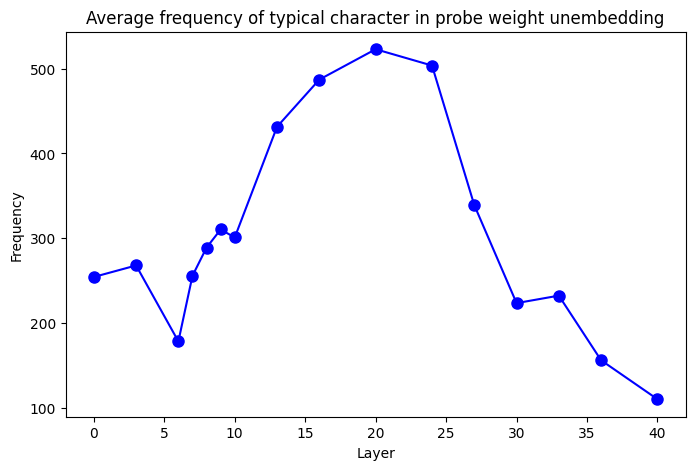

In [74]:
import matplotlib.pyplot as plt
layers = list(frequency_characteristic_character.keys())
quantities = list(frequency_characteristic_character.values())

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(layers, quantities, color='blue', linestyle='-', marker='o', markersize=8)

# Add labels and title
plt.xlabel('Layer')
plt.ylabel('Frequency')
plt.title('Average frequency of typical character in probe weight unembedding')

plt.savefig('phonetic_character_of_rhyme_representation.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

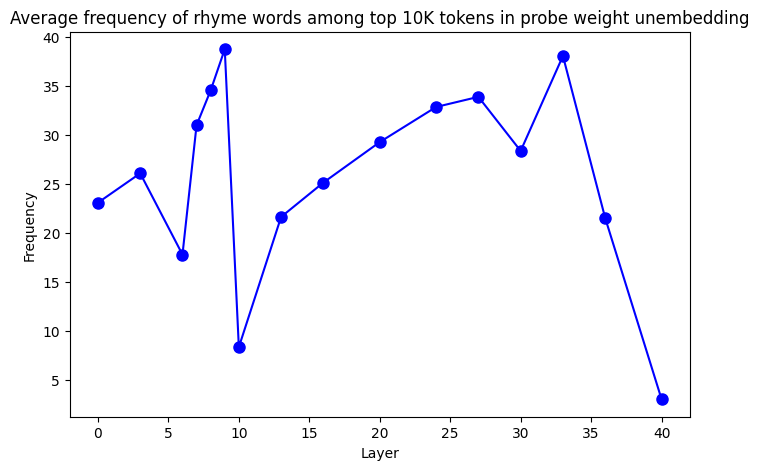

In [75]:
layers = list(frequency_top_logit.keys())
quantities = list(frequency_top_logit.values())

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(layers, quantities, color='blue', linestyle='-', marker='o', markersize=8)

# Add labels and title
plt.xlabel('Layer')
plt.ylabel('Frequency')
plt.title('Average frequency of rhyme words among top 10K tokens in probe weight unembedding')

plt.savefig('rhymed_wrd_rank_rhyme_representation.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

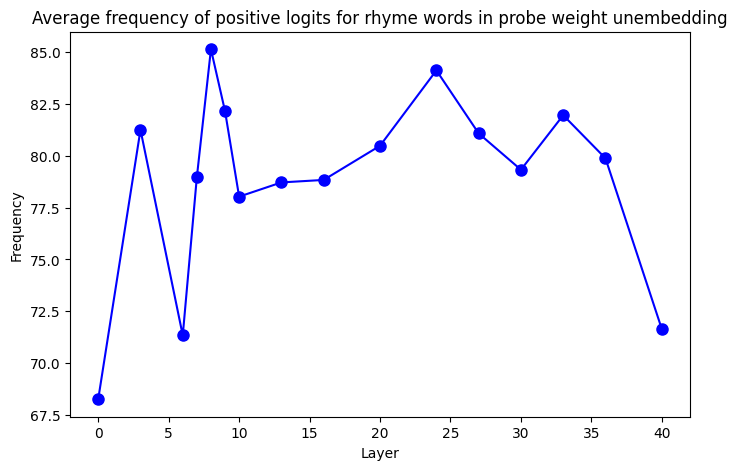

In [76]:
layers = list(frequency_positive_logit.keys())
quantities = list(frequency_positive_logit.values())

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(layers, quantities, color='blue', linestyle='-', marker='o', markersize=8)

# Add labels and title
plt.xlabel('Layer')
plt.ylabel('Frequency')
plt.title('Average frequency of positive logits for rhyme words in probe weight unembedding')

plt.savefig('rhymed_wrd_poslogit_rhyme_representation.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()